# 27 Opening OBJ and DXF Files with PyVista in GemGIS

OBJ and DXF Files can be opened with GemGIS and visualized with PyVista. 



<img src="../images/tutorial27_cover.png">

## Set File Paths

If you downloaded the latest `GemGIS` from the Github repository, append the path so that the package can be imported successfully. In addition, the file path to the files within the `gemgis_data` folder is set. You can download the data [here](https://github.com/cgre-aachen/gemgis_data/archive/master.zip) if you have not done so.

In [1]:
import sys
sys.path.append('../../../../gemgis')
file_path ='../../../../gemgis_data/data/27_opening_obj_and_dxf_files/'

## Loading OBJ File using PyVista

The obj file can easily be loaded and plotted using PyVista.

In [2]:
import gemgis as gg
import pyvista as pv

mesh = pv.read(file_path + 'Channel.obj')
mesh

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


PolyData (0x25a1099b940)
  N Cells:	49152
  N Points:	196608
  X Bounds:	-1.576e+00, 2.530e+00
  Y Bounds:	-9.167e-01, 1.000e+00
  Z Bounds:	-1.000e+00, 9.751e+00
  N Arrays:	5

## Plotting the mesh using PyVista

The loaded mesh can be plotted using PyVista again.

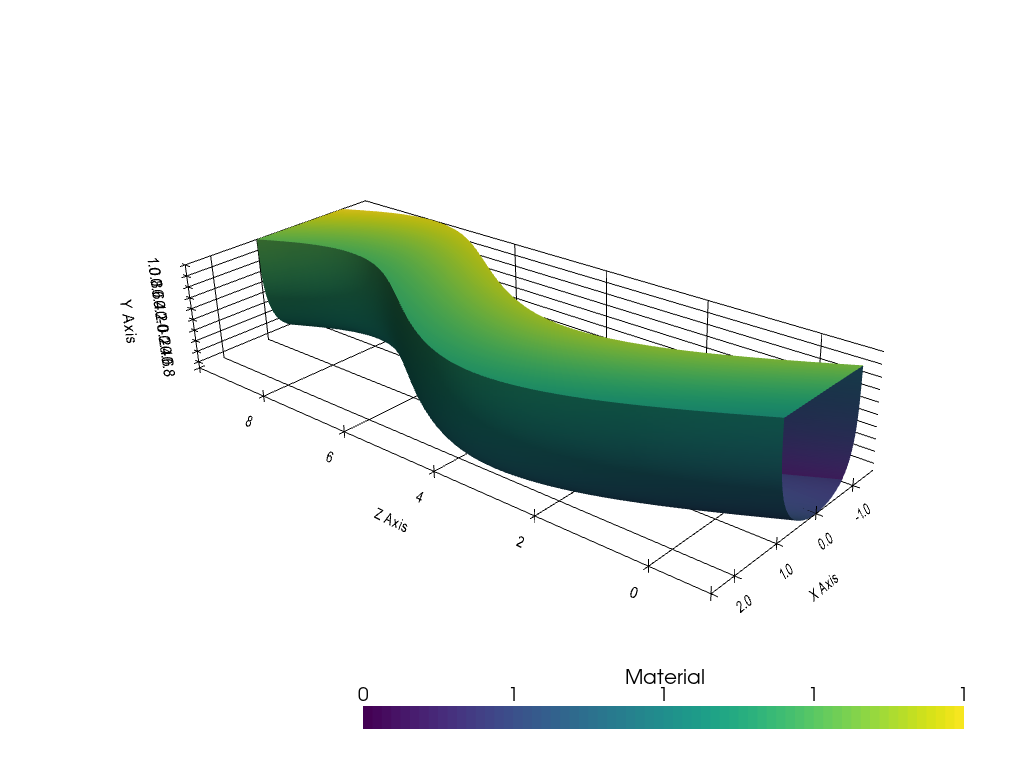

In [3]:
sargs = dict(fmt="%.0f", color='black')

p = pv.Plotter(notebook=True)

p.add_mesh(mesh,scalar_bar_args=sargs)

p.camera_position=[(15.33958702947096, 9.654312885616765, -9.581353852513592),
 (0.5404866466699564, -0.29141440140763164, 4.2033639107058445),
 (-0.3459193991987702, 0.8968436300281839, 0.2757014191763108)]

p.set_background('white')
p.show_grid(color='black')
p.show()

## Loading the DXF File using GeoPandas

DXF Files can be loaded using GeoPandas. The faces are then stored as ``POLYGON Z`` objects containing not only the X and Y values but also a Z value. Each polygon is made of 3 vertices of which the start and endpoint are identical (3 different vertices). In order to build the mesh, the vertices need to be extracted. The faces are equal to the single polygons.

In [4]:
import geopandas as gpd

gdf = gpd.read_file(file_path + 'Channel.dxf')
gdf.drop(['Layer', 'PaperSpace','SubClasses','Linetype', 'EntityHandle', 'Text'], axis=1).head()

geometry
0  POLYGON Z ((1.00869 0.92852 1.00000, 0.97744 0...
1  POLYGON Z ((1.00869 0.92852 1.00000, 1.01735 0...
2  POLYGON Z ((0.97744 0.92853 1.00000, 0.94619 0...
3  POLYGON Z ((0.97744 0.92853 1.00000, 0.98610 0...
4  POLYGON Z ((0.94619 0.92853 1.00000, 0.91494 0...

### Inspecting the Geometries

Each geometry object is a polygon consisting of three unique vertices.

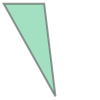

In [5]:
gdf.loc[0].geometry

In [6]:
type(gdf.loc[0].geometry)

shapely.geometry.polygon.Polygon

In [7]:
gdf.loc[0].geometry.wkt

'POLYGON Z ((1.008687376976013 0.9285249710083008 1, 0.9774374961853027 0.9285261631011963 1, 1.017350554466248 0.8570554852485657 1.00000011920929, 1.008687376976013 0.9285249710083008 1))'

### Extracting XYZ Coordinates of Polygons

The coordinates for each vertex of each Polygon can be extracted using the regular ``extract_xy(..)`` function again. The function was adapted to also work with geometries containing a Z component. 

In [8]:
gdf_lines = gg.vector.extract_xy(gdf)
gdf_lines.head()

Layer PaperSpace SubClasses Linetype EntityHandle  Text  \
0     0       None       None     None         None  None   
1     0       None       None     None         None  None   
2     0       None       None     None         None  None   
3     0       None       None     None         None  None   
4     0       None       None     None         None  None   

                  geometry    X    Y    Z  
0  POINT (1.00869 0.92852) 1.01 0.93 1.00  
1  POINT (0.97744 0.92853) 0.98 0.93 1.00  
2  POINT (1.01735 0.85706) 1.02 0.86 1.00  
3  POINT (1.00869 0.92852) 1.01 0.93 1.00  
4  POINT (1.00869 0.92852) 1.01 0.93 1.00

### Showing vertices

The vertices to create a mesh are equal to the X, Y and Z values of the GeoDataFrame as NumPy array.

In [9]:
vertices = gdf_lines[['X', 'Y', 'Z']].values
vertices

array([[ 1.00868738,  0.92852497,  1.        ],
       [ 0.9774375 ,  0.92852616,  1.        ],
       [ 1.01735055,  0.85705549,  1.00000012],
       ...,
       [ 0.24864995, -7.21182299, -0.65079874],
       [ 0.23326781, -7.21196413, -0.66666669],
       [ 0.25142166, -7.16530943, -0.66666669]])

### Showing Faces

The faces for the mesh are equal to the indices of the single points within the GeoDataFrame in the needed VTK format.

In [10]:
import numpy as np
faces = np.pad(np.arange(0,len(gdf_lines[['X', 'Y', 'Z']].values)).reshape(int(len(gdf_lines[['X', 'Y', 'Z']].values)/4), 4), ((0, 0), (1, 0)), 'constant', constant_values=4)
faces

array([[     4,      0,      1,      2,      3],
       [     4,      4,      5,      6,      7],
       [     4,      8,      9,     10,     11],
       ...,
       [     4, 393204, 393205, 393206, 393207],
       [     4, 393208, 393209, 393210, 393211],
       [     4, 393212, 393213, 393214, 393215]])

### Creating PolyData

A PyVista PolyData dataset can easily be created with the vertices and faces.

In [11]:
poly = pv.PolyData(vertices, faces)
poly

PolyData (0x25a10ad1f40)
  N Cells:	98304
  N Points:	393216
  X Bounds:	-1.576e+00, 2.530e+00
  Y Bounds:	-9.751e+00, 1.000e+00
  Z Bounds:	-9.167e-01, 1.000e+00
  N Arrays:	0

### Plotting the mesh

As usual, the mesh can be plotted using PyVista.

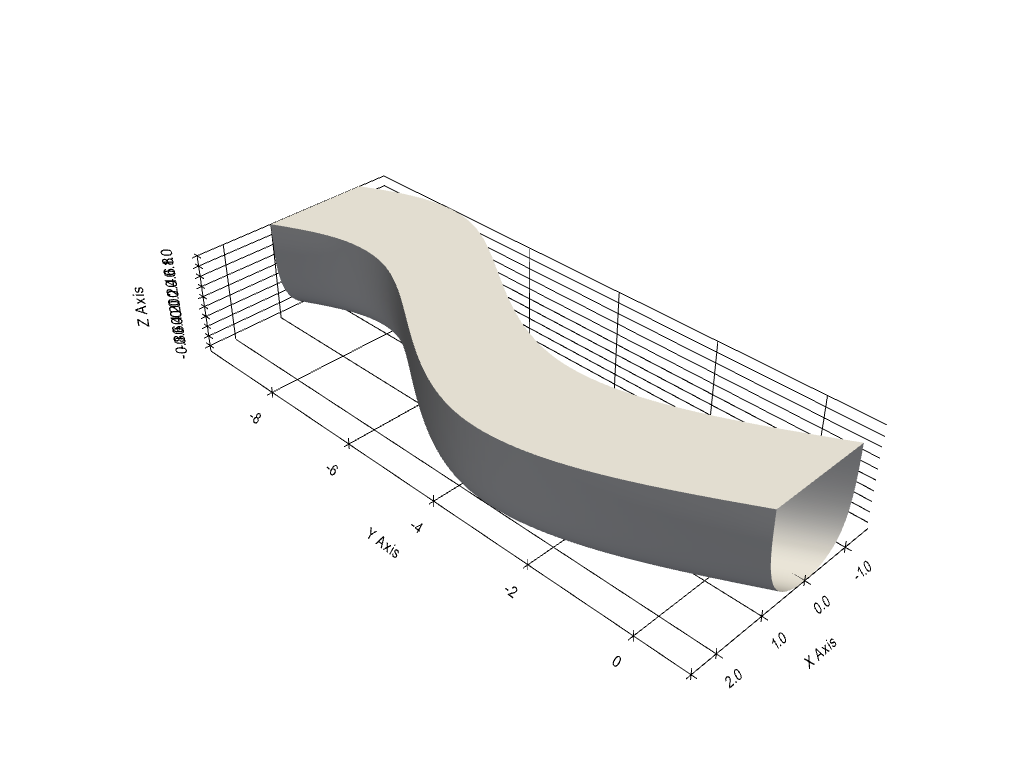

In [12]:
sargs = dict(fmt="%.0f", color='black')

p = pv.Plotter(notebook=True)

p.add_mesh(poly,scalar_bar_args=sargs)

p.set_background('white')
p.show_grid(color='black')
p.show()

## Using the built-in GemGIS Function

The PolyData dataset can also be created using the built-in GemGIS function ``create_polydata_from_dxf(...)``.

In [13]:
poly = gg.visualization.create_polydata_from_dxf(gdf=gdf)

TypeError: All geometries must be of geom_type LineString

In [ ]:
sargs = dict(fmt="%.0f", color='black')

p = pv.Plotter(notebook=True)

p.add_mesh(poly,scalar_bar_args=sargs)

p.set_background('white')
p.show_grid(color='black')
p.show()